In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc 

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

In [2]:
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

In [10]:
DATA_DIR = '../Raw_Data/'  

In [11]:
def reduce_mem_usage(df, use_float16=False):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#        else:
#            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
df_meta = pd.read_csv(DATA_DIR + 'building_metadata.csv')
print("Building Meta Shape:", df_meta.shape)

df_weather = pd.read_csv(DATA_DIR + 'weather_train.csv')
print("Weather Train Shape:", df_weather.shape)

df_power_meter = pd.read_csv(DATA_DIR + 'train.csv') 
df_power_meter = reduce_mem_usage(df_power_meter)
print("Weather Train Shape:", df_power_meter.shape)

df_power_meter['timestamp'] = pd.to_datetime(df_power_meter['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

print("\nData Loaded Successfully!")

Building Meta Shape: (1449, 6)
Weather Train Shape: (139773, 9)
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Weather Train Shape: (20216100, 4)


/tmp/ipykernel_12371/3725526642.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_datetime(df[col]) or is_categorical_dtype(df[col]):
/tmp/ipykernel_12371/3725526642.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_datetime(df[col]) or is_categorical_dtype(df[col]):
/tmp/ipykernel_12371/3725526642.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_datetime(df[col]) or is_categorical_dtype(df[col]):



Data Loaded Successfully!


In [14]:
print("Power Meter Timestamp Range:")
print("  Start:", df_power_meter['timestamp'].min())
print("  End  :", df_power_meter['timestamp'].max())

print("\nWeather Timestamp Range:")
print("  Start:", df_weather['timestamp'].min())
print("  End  :", df_weather['timestamp'].max())

Power Meter Timestamp Range:
  Start: 2016-01-01 00:00:00
  End  : 2016-12-31 23:00:00

Weather Timestamp Range:
  Start: 2016-01-01 00:00:00
  End  : 2016-12-31 23:00:00


In [16]:
df_power_meter.duplicated().sum()

np.int64(0)

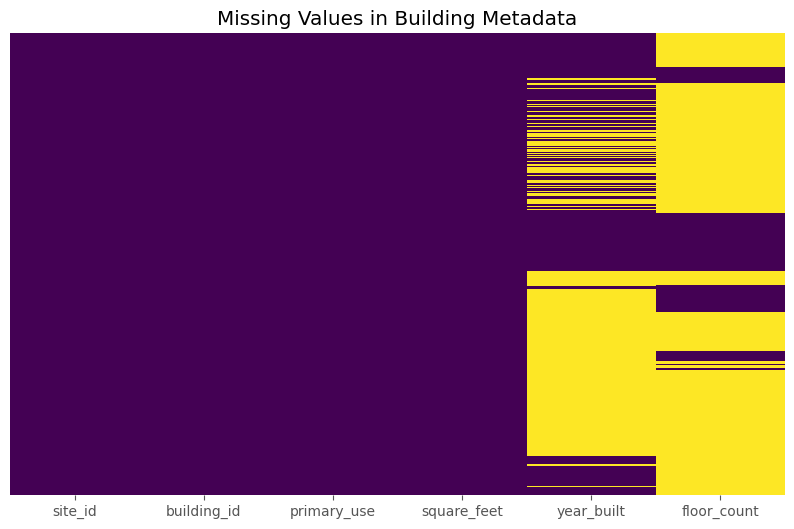

year_built     53.416149
floor_count    75.500345
dtype: float64


In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(building_meta.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values in Building Metadata")
plt.show()

missing_stats = building_meta.isnull().sum() / len(building_meta) * 100
print(missing_stats[missing_stats > 0])

Observation: Floor_count and year_built have massive amounts of missing data.
Decision for Pipeline: We must configure our MariaDB schema to allow NULL for these columns, or drop them if they are too empty. We cannot set NOT NULL constraints on these.

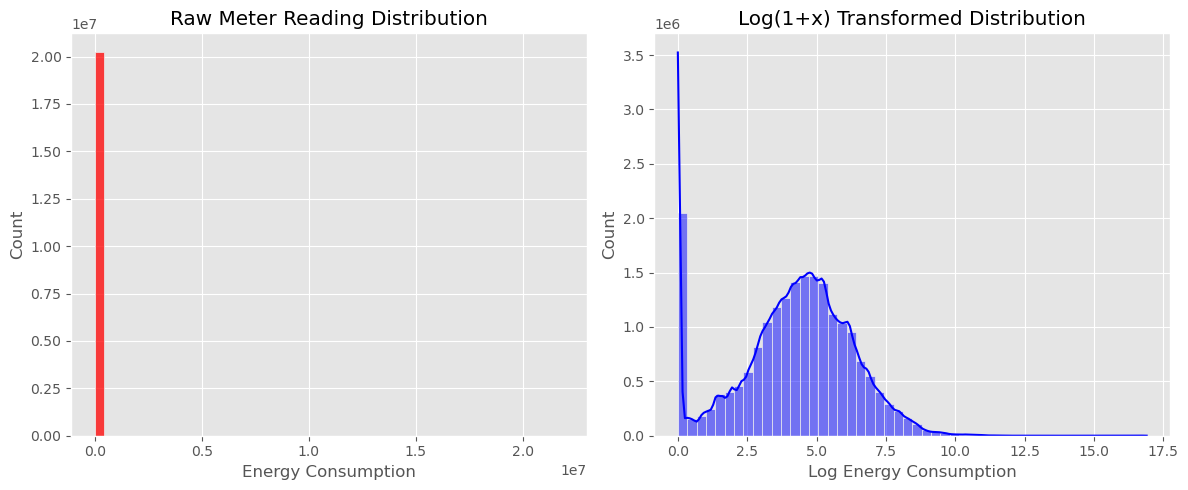

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train['meter_reading'].dropna(), bins=50, kde=False, color='red')
plt.title("Raw Meter Reading Distribution")
plt.xlabel("Energy Consumption")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['meter_reading'].dropna()), bins=50, kde=True, color='blue')
plt.title("Log(1+x) Transformed Distribution")
plt.xlabel("Log Energy Consumption")

plt.tight_layout()
plt.show()

Observation: The raw data (Red) looks like a single bar on the left with a long tail. The Log data (Blue) looks more like a Bell Curve (Normal Distribution).
Decision for Pipeline: In Stage 2 (Preprocessing), we must apply np.log1p() to the target variable before training, and np.expm1() (inverse log) after prediction.

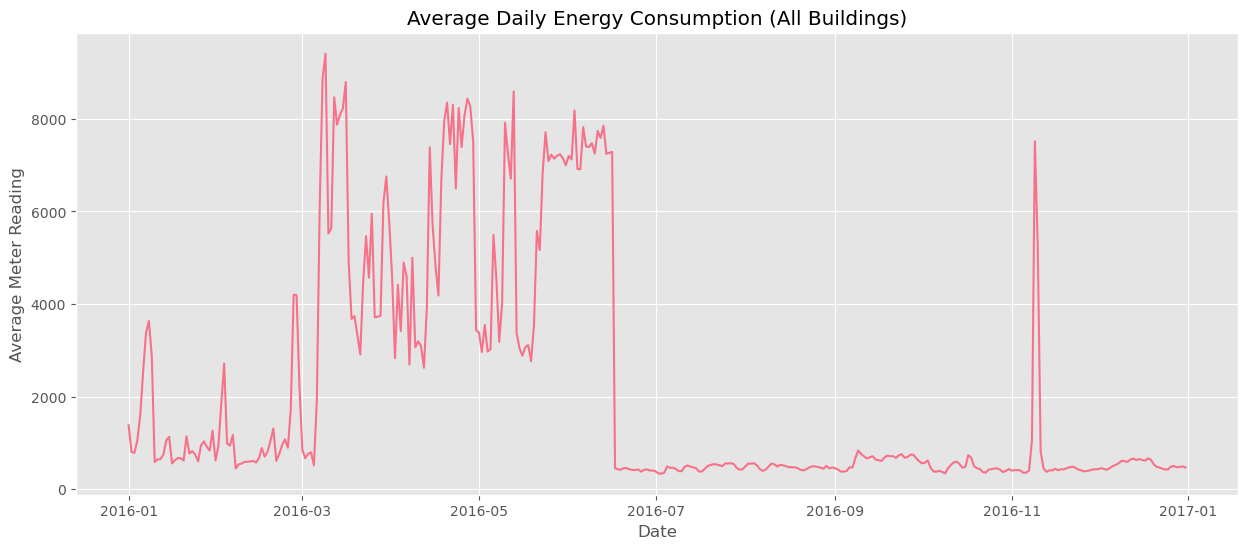

In [14]:
daily_avg = train.groupby(train['timestamp'].dt.date)['meter_reading'].mean()

plt.figure(figsize=(15, 6))
daily_avg.plot()
plt.title("Average Daily Energy Consumption (All Buildings)")
plt.ylabel("Average Meter Reading")
plt.xlabel("Date")
plt.show()

Observation: Peaks and troughs. This proves Seasonality.
Decision for Pipeline: This confirms we need EvidentlyAI. If we train on data from January (Winter) and predict on July (Summer), the model might fail. We need to monitor this.

(8784, 12)


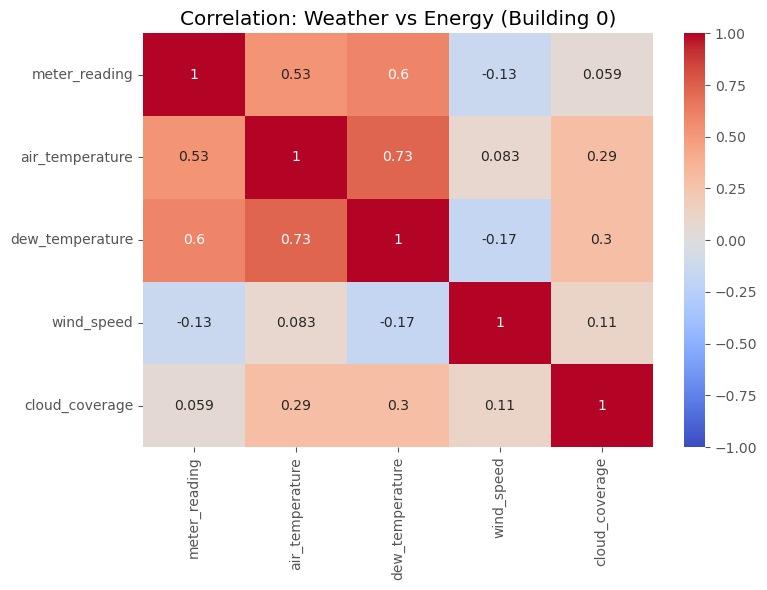

In [16]:
bldg_0 = train[train['building_id'] == 0].copy()

bldg_0 = bldg_0.merge(
    building_meta[['building_id', 'site_id']],
    on='building_id',
    how='left'
)

bldg_0 = bldg_0.merge(
    weather_train,
    on=['site_id', 'timestamp'],
    how='left'
)

print(bldg_0.shape)

corr_cols = [
    'meter_reading',
    'air_temperature',
    'dew_temperature',
    'wind_speed',
    'cloud_coverage'
]

corr = bldg_0[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Correlation: Weather vs Energy (Building 0)")
plt.tight_layout()
plt.show()


Observation: Correlation between meter_reading and air_temperature.
Decision for Pipeline: This scientifically proves we must ingest the weather.csv file and join it to the readings. It justifies the Star Schema design.

## UTILITY FUNCTION 

In [17]:
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [26]:
print(len(df_power_meter), len(df_meta), len(df_weather))

20216100 1449 139773


## Weather Data Cleanup 

In [27]:
df_weather.head(10)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
5,0,2016-01-01 05:00:00,19.4,NaN,19.4,0.0,NaN,0.0,0.0
6,0,2016-01-01 06:00:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0
7,0,2016-01-01 07:00:00,21.1,NaN,21.1,0.0,1018.8,210.0,1.5
8,0,2016-01-01 08:00:00,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
9,0,2016-01-01 09:00:00,21.1,NaN,20.6,0.0,1019.0,290.0,1.5


In [28]:
missing_statistics(df_weather)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,139773,0.00
1,timestamp,0,139773,0.00
2,air_temperature,55,139773,0.04
3,cloud_coverage,69173,139773,49.49
4,dew_temperature,113,139773,0.08
5,precip_depth_1_hr,50289,139773,35.98
6,sea_level_pressure,10618,139773,7.60
7,wind_direction,6268,139773,4.48
8,wind_speed,304,139773,0.22


In [29]:
df_weather["datetime"] = pd.to_datetime(df_weather["timestamp"])
df_weather["day"] = df_weather["datetime"].dt.day
df_weather["week"] = df_weather["datetime"].dt.isocalendar().week
df_weather["month"] = df_weather["datetime"].dt.month

In [30]:
df_weather = df_weather.set_index(['site_id','day','month'])

In [31]:
air_temperature_filler = pd.DataFrame(df_weather.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
df_weather.update(air_temperature_filler,overwrite=False)

In [32]:
cloud_coverage_filler = df_weather.groupby(['site_id','day','month'])['cloud_coverage'].mean()

cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

df_weather.update(cloud_coverage_filler,overwrite=False)

/tmp/ipykernel_5731/556968769.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])


In [33]:
dew_temperature_filler = pd.DataFrame(df_weather.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
df_weather.update(dew_temperature_filler,overwrite=False)

In [34]:
sea_level_filler = df_weather.groupby(['site_id','day','month'])['sea_level_pressure'].mean()

sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

df_weather.update(sea_level_filler,overwrite=False)

/tmp/ipykernel_5731/15115448.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])


In [35]:
wind_direction_filler =  pd.DataFrame(df_weather.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
df_weather.update(wind_direction_filler,overwrite=False)

In [36]:
wind_speed_filler =  pd.DataFrame(df_weather.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
df_weather.update(wind_speed_filler,overwrite=False)

In [37]:
precip_depth_filler = df_weather.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()

precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

df_weather.update(precip_depth_filler,overwrite=False)

/tmp/ipykernel_5731/3681248729.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])


In [38]:
missing_statistics(df_weather)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,timestamp,0,139773,0.0
1,air_temperature,0,139773,0.0
2,cloud_coverage,0,139773,0.0
3,dew_temperature,0,139773,0.0
4,precip_depth_1_hr,0,139773,0.0
5,sea_level_pressure,0,139773,0.0
6,wind_direction,0,139773,0.0
7,wind_speed,0,139773,0.0
8,datetime,0,139773,0.0
9,week,0,139773,0.0


In [39]:
df_weather.head()

timestamp  air_temperature  cloud_coverage  \
site_id day month                                                        
0       1   1     2016-01-01 00:00:00             25.0        6.000000   
            1     2016-01-01 01:00:00             24.4        4.285714   
            1     2016-01-01 02:00:00             22.8        2.000000   
            1     2016-01-01 03:00:00             21.1        2.000000   
            1     2016-01-01 04:00:00             20.0        2.000000   

                   dew_temperature  precip_depth_1_hr  sea_level_pressure  \
site_id day month                                                           
0       1   1                 20.0          -0.173913              1019.7   
            1                 21.1          -1.000000              1020.2   
            1                 21.1           0.000000              1020.2   
            1                 20.6           0.000000              1020.1   
            1                 20.0          -1.000000              1020.0   

                   wind_direction  wind_speed            datetime  week  
site_id day month                                                        
0       1   1                 0.0         0.0 2016-01-01 00:00:00    53  
            1                70.0         1.5 2016-01-01 01:00:00    53  
            1                 0.0         0.0 2016-01-01 02:00:00    53  
            1                 0.0         0.0 2016-01-01 03:00:00    53  
            1               250.0         2.6 2016-01-01 04:00:00    53

In [40]:
df_weather = df_weather.reset_index()
# df_weather = df_weather.drop(['datetime','day','week','month'],axis=1)

print(len(df_weather))
df_weather.head()

139773


,site_id,day,month,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,datetime,week
0,0,1,1,2016-01-01 00:00:00,25.0,6.000000,20.0,-0.173913,1019.7,0.0,0.0,2016-01-01 00:00:00,53
1,0,1,1,2016-01-01 01:00:00,24.4,4.285714,21.1,-1.000000,1020.2,70.0,1.5,2016-01-01 01:00:00,53
2,0,1,1,2016-01-01 02:00:00,22.8,2.000000,21.1,0.000000,1020.2,0.0,0.0,2016-01-01 02:00:00,53
3,0,1,1,2016-01-01 03:00:00,21.1,2.000000,20.6,0.000000,1020.1,0.0,0.0,2016-01-01 03:00:00,53
4,0,1,1,2016-01-01 04:00:00,20.0,2.000000,20.0,-1.000000,1020.0,250.0,2.6,2016-01-01 04:00:00,53


In [41]:
missing_statistics(df_meta)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,1449,0.00
1,building_id,0,1449,0.00
2,primary_use,0,1449,0.00
3,square_feet,0,1449,0.00
4,year_built,774,1449,53.42
5,floor_count,1094,1449,75.50


1. Strategy for floor_count (75.5% Missing)
Verdict: DROP THE COLUMN.
Reasoning: With 3/4 of the data missing, any attempt to guess (impute) the values will introduce more noise than signal.
Proxy: You already have square_feet (0% missing). Square footage is a much better indicator of building size and energy consumption than the number of floors. You don't need both.

2. Strategy for year_built (53.4% Missing)
Verdict: KEEP & IMPUTE (SMARTLY).
Reasoning: The age of a building is critical for energy efficiency (old insulation vs. modern standards).
The Solution: Do not just fill with the average (Mean). That would say "53% of our buildings were built in 1968," which is false.
Method: Fill with a specific "Unknown" identifier (like -999 or NaN) and let the Machine Learning model handle it.
Why? You are using XGBoost (as per your pipeline design). XGBoost is famous because it can natively handle NaN values. It learns to split data based on "Is the age known?" vs "Is the age unknown?".

In [43]:
missing_statistics(df_power_meter) 

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.0
1,meter,0,20216100,0.0
2,timestamp,0,20216100,0.0
3,meter_reading,0,20216100,0.0
